In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv("data/IMDB.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def clean_text(text):
    text = re.sub('<br />', ' ', text)  
    text = re.sub('[^a-zA-Z]', ' ', text)  
    return text.lower()

df['cleaned_reviews'] = df['review'].apply(clean_text)


In [4]:
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...


In [5]:
X = df['cleaned_reviews']
y = df['sentiment'].map({'positive': 1, 'negative': -1})  # Convert to 1 and -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


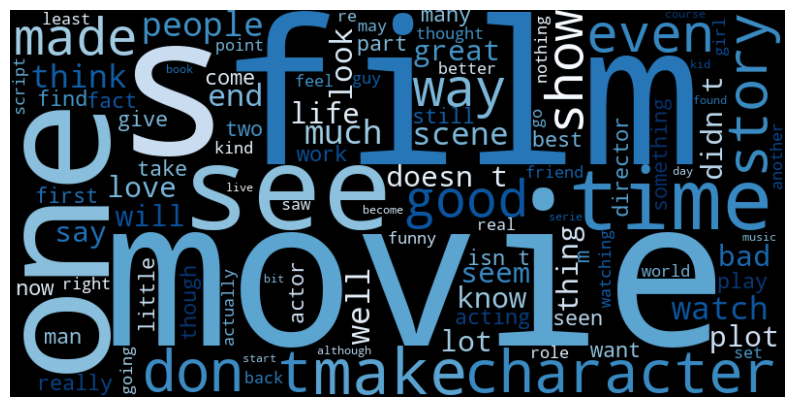

In [25]:
from wordcloud import WordCloud

# Join all reviews into a single string
all_text = ' '.join(df['cleaned_reviews'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues', max_words=100).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("results/MovieWordCloud.png")
plt.show()


In [ ]:
# Import the TF-IDF Vectorizer from sklearn's feature extraction module
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  

# Transform the training text data into TF-IDF features
# 'max_features=5000' limits the vocabulary to the 5,000 most important words
# 'stop_words="english"' removes common English words (like "the", "is") to focus on meaningful words
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test text data using the same fitted vectorizer
# This ensures that the same vocabulary and weight calculations are applied to the test data
X_test_tfidf = vectorizer.transform(X_test)


In [7]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [14]:
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n\n\n")



print(classification_report(y_test, y_pred))


Accuracy: 0.8884



              precision    recall  f1-score   support

          -1       0.90      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



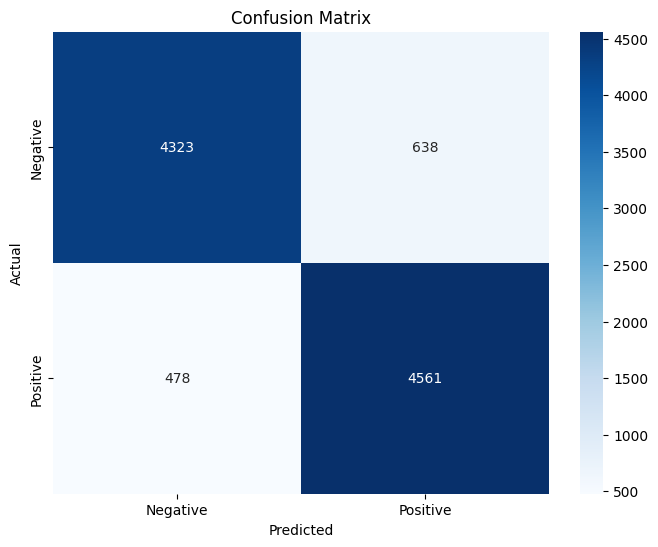

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


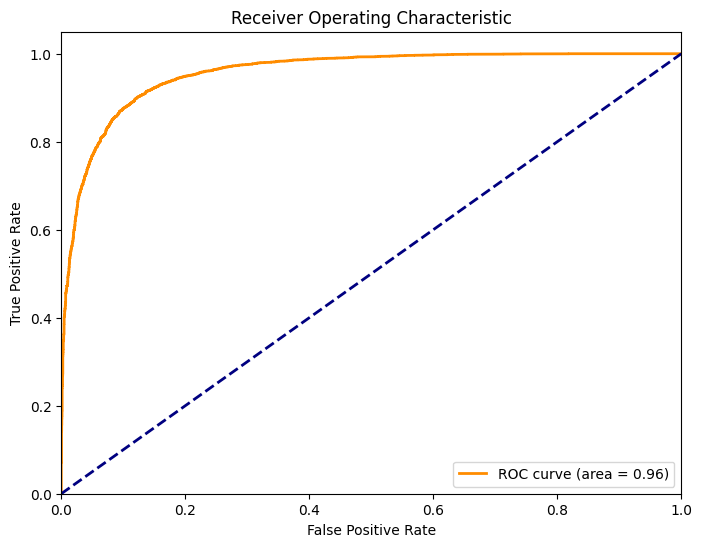

In [10]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class
y_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers for logistic regression
}

# Initialize the grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)


c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\warne\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Best parameters found:  {'C': 1, 'solver': 'liblinear'}


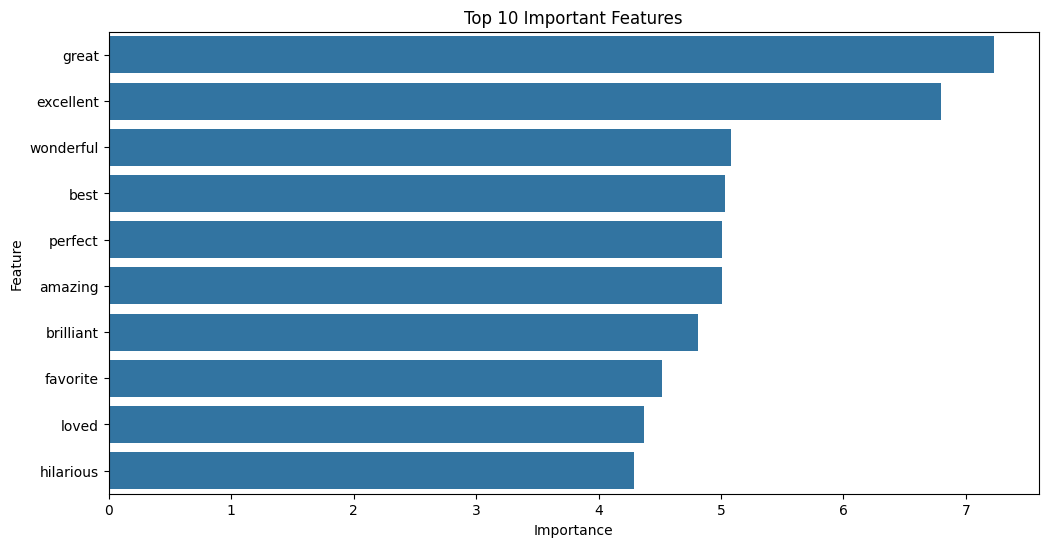

In [12]:
# Get feature importance
feature_importance = model.coef_[0]
features = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize top 10 important features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()
